In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler


In [2]:
# Load the data
data = pd.read_csv('node2_data.csv')

In [3]:
data['needs_charge'] = np.where(data['charge'] <= 40, 1, 0)

DATA CLEANING

In [4]:
# Data Cleaning
data = pd.get_dummies(data, columns=['weather', 'traffic', 'road_gradient', 'emergency', 'car_status'])

# Check the column names
print(data.columns)

Index(['timestamp', 'car_id', 'model', 'current_speed', 'battery_capacity',
       'charge', 'consumption', 'location', 'node', 'distance_covered',
       'battery_life', 'distance_to_charging_point', 'emergency_duration',
       'needs_charge', 'weather_rainy', 'weather_snowy', 'weather_sunny',
       'traffic_heavy', 'traffic_light', 'traffic_moderate',
       'road_gradient_downhill', 'road_gradient_flat', 'road_gradient_uphill',
       'emergency_accident_ahead', 'emergency_none', 'emergency_road_closure',
       'car_status_Charging', 'car_status_Moving', 'car_status_moving',
       'car_status_rerouting', 'car_status_stopped'],
      dtype='object')


In [5]:
## Remove duplicates
data = data.drop_duplicates()

# Drop other non-numeric columns if any
data = data.select_dtypes(include=[float, int])

In [6]:
## Handle outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

Feature Selection

In [7]:
# Feature Selection
features = ['current_speed', 'battery_capacity', 'charge', 'consumption', 'distance_covered', 'battery_life', 'distance_to_charging_point']
features += [col for col in data if 'weather_' in col]
features += [col for col in data if 'traffic_' in col]
features += [col for col in data if 'road_gradient_' in col]
features += [col for col in data if 'emergency_' in col]
features += [col for col in data if 'car_status_' in col]

X = data[features]
y = data['needs_charge']

print(X.head())

    current_speed  battery_capacity     charge  consumption  distance_covered  \
10             50                38  88.996103         0.09          5.033333   
12             42                38  88.888401         0.09          5.866667   
14             30                38  88.812995         0.09          6.566667   
16             14                38  88.775275         0.09          7.066667   
18             13                38  88.767715         0.09          7.300000   

    battery_life  distance_to_charging_point  emergency_duration  
10        99.996                  184.966667                   0  
12        99.995                  184.133333                   0  
14        99.994                  183.433333                   0  
16        99.993                  182.933333                   0  
18        99.992                  182.700000                   0  


In [8]:
print(data['charge'].describe())
print(data['needs_charge'].value_counts())


count    7042.000000
mean       65.591324
std        15.584060
min        40.000466
25%        51.792015
50%        62.384887
75%        79.507783
max       100.000000
Name: charge, dtype: float64
needs_charge
0    7042
Name: count, dtype: int64


In [9]:
print(data['needs_charge'].value_counts())

needs_charge
0    7042
Name: count, dtype: int64


In [10]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Data Visualization

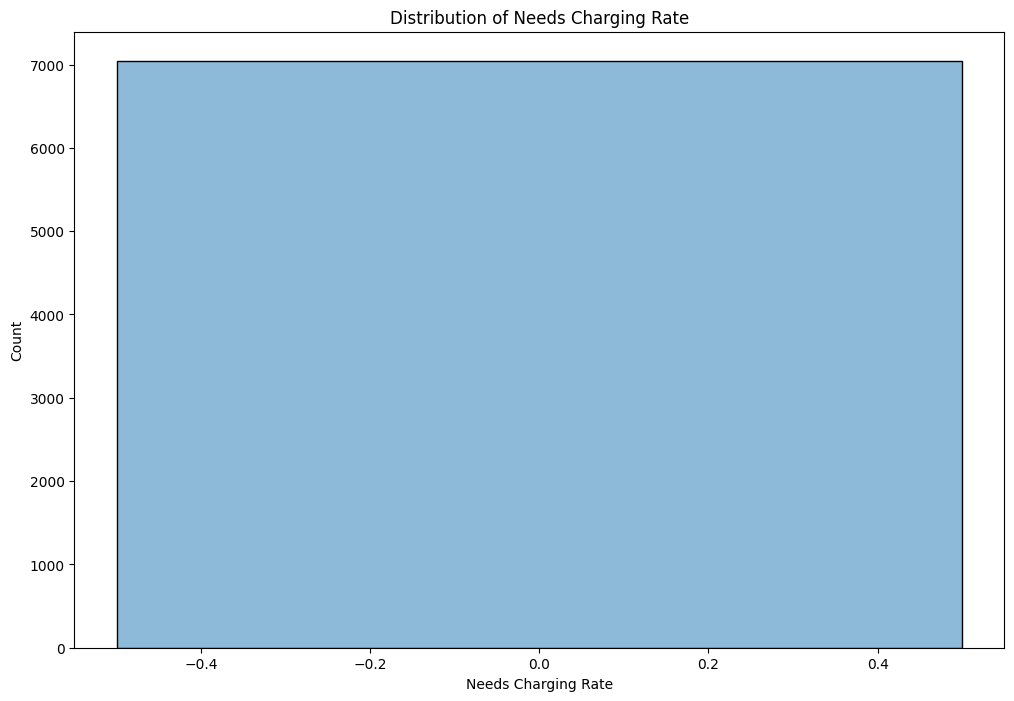

In [12]:
# Distribution of the target variable
plt.figure(figsize=(12,8))
sns.histplot(data['needs_charge'], kde=True)
plt.title('Distribution of Needs Charging Rate')
plt.xlabel('Needs Charging Rate')
plt.ylabel('Count')
plt.show()

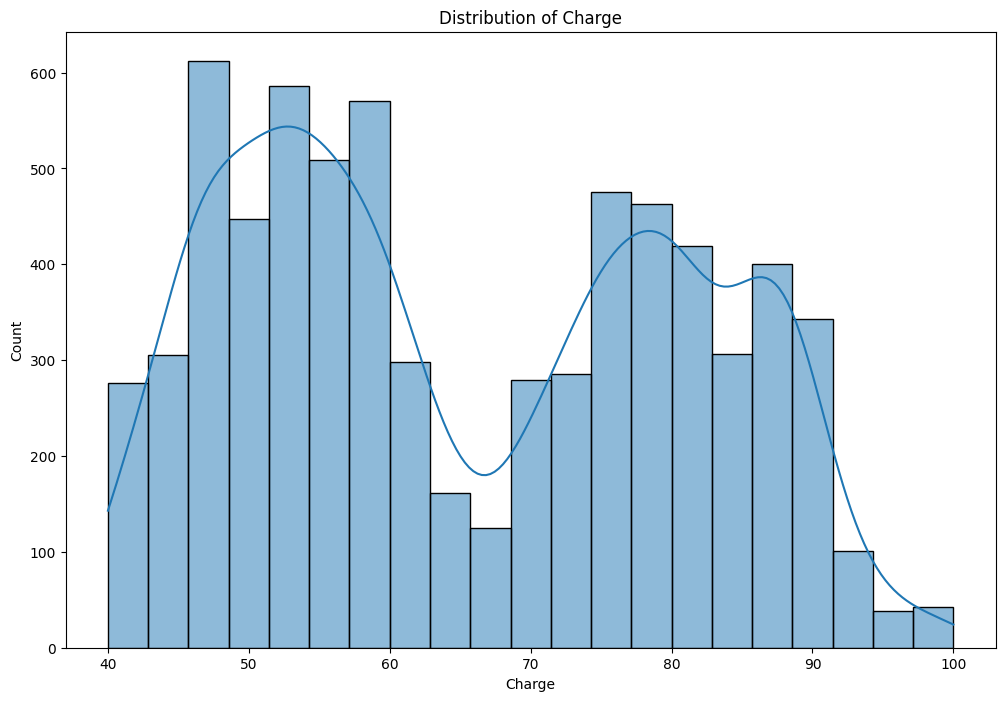

In [13]:
# plot the distribution 
plt.figure(figsize=(12,8))
sns.histplot(data['charge'], kde=True)
plt.title('Distribution of Charge')
plt.xlabel('Charge')
plt.ylabel('Count')
plt.show()


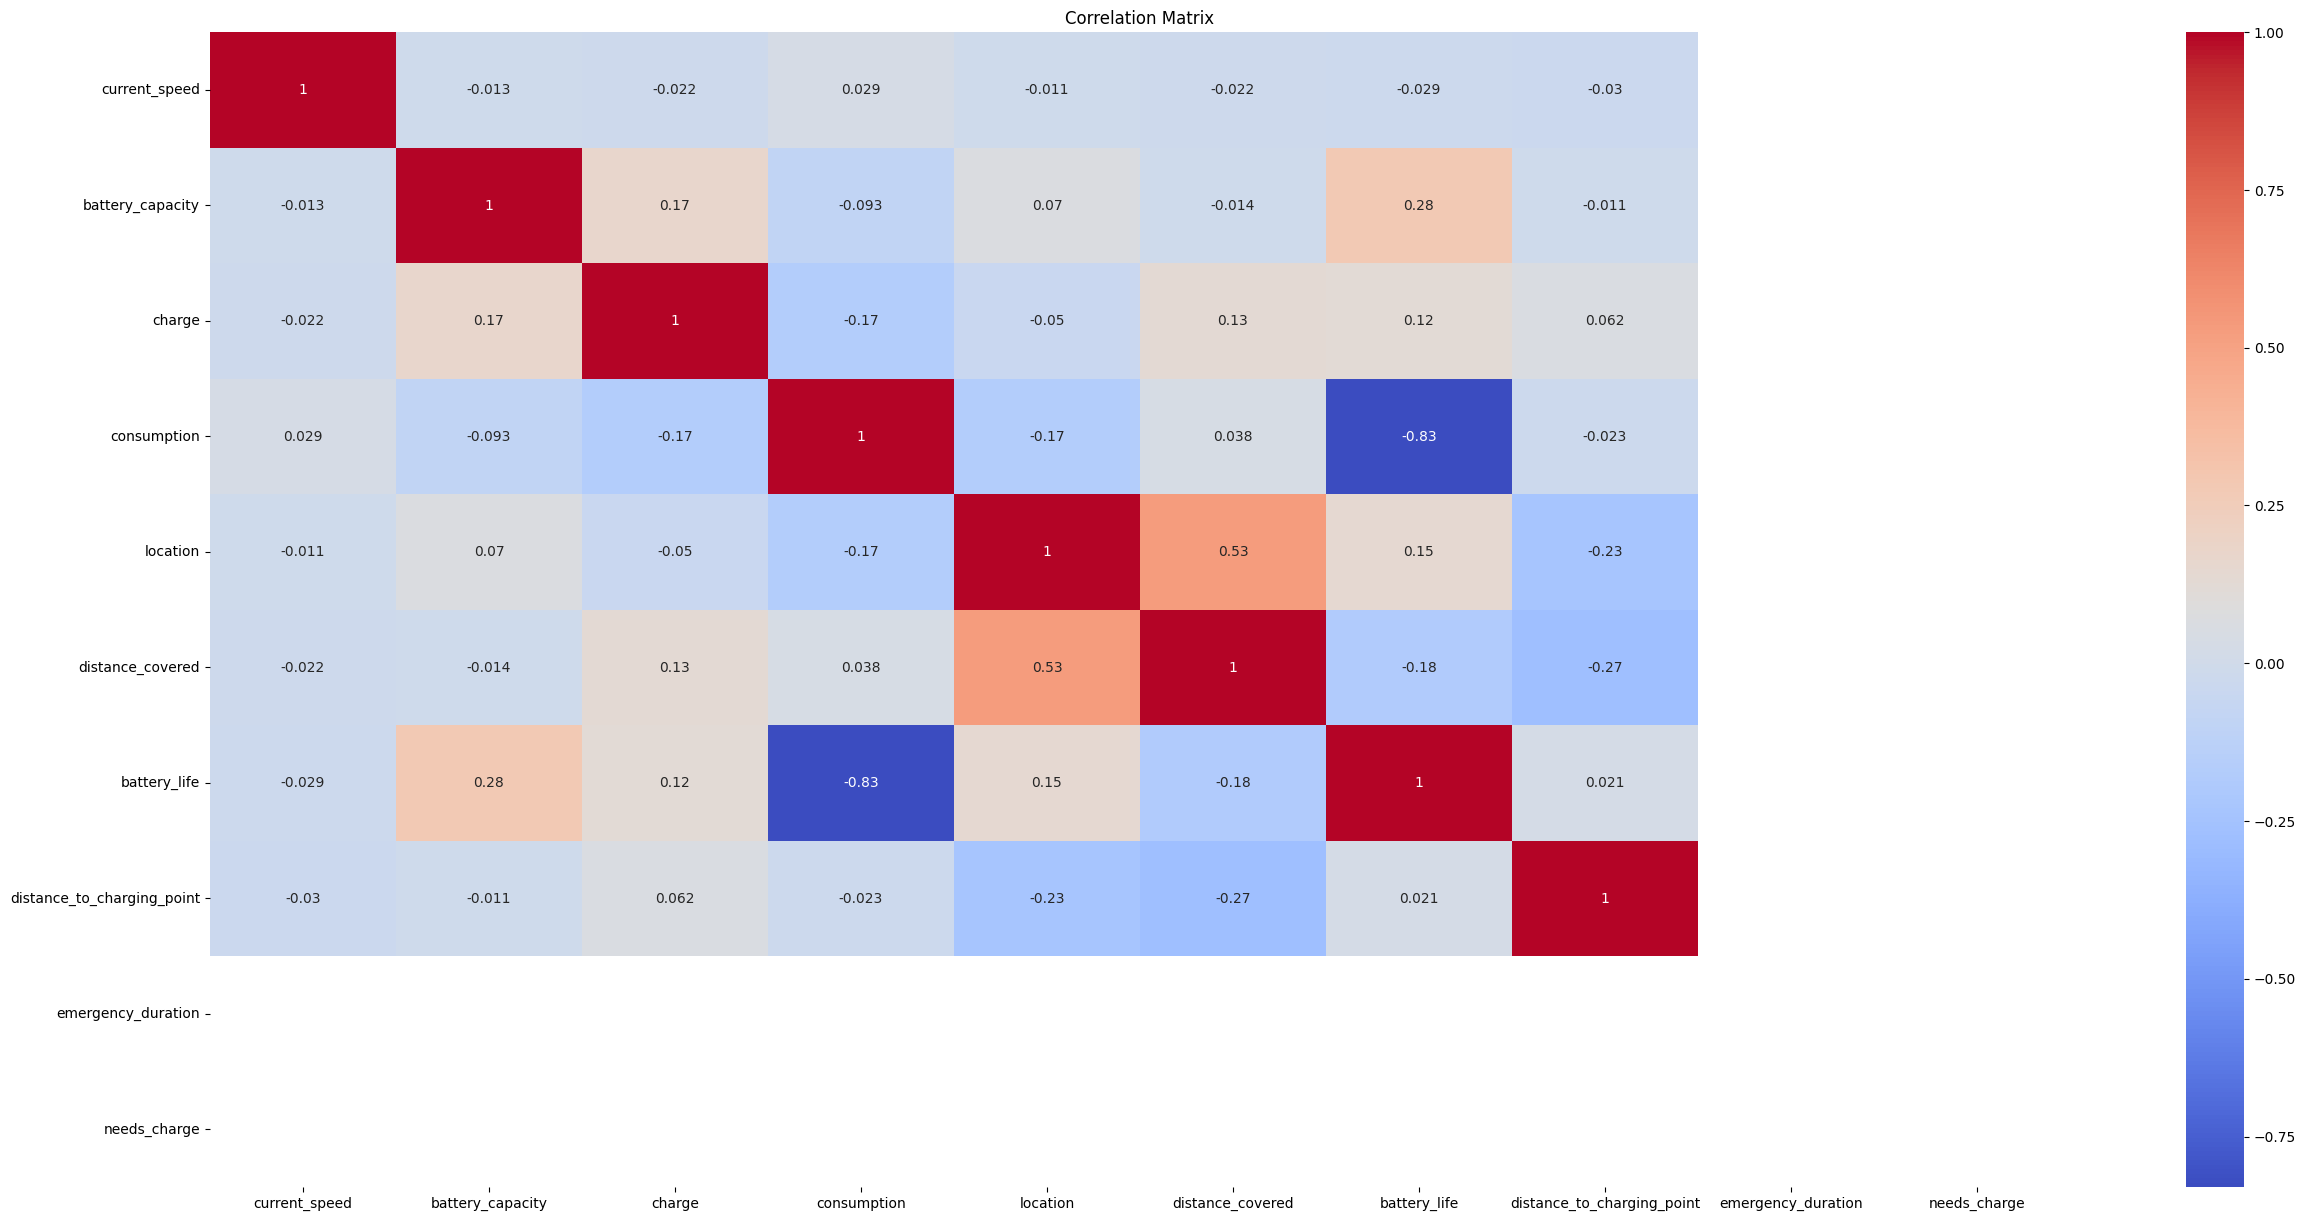

In [14]:
## Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

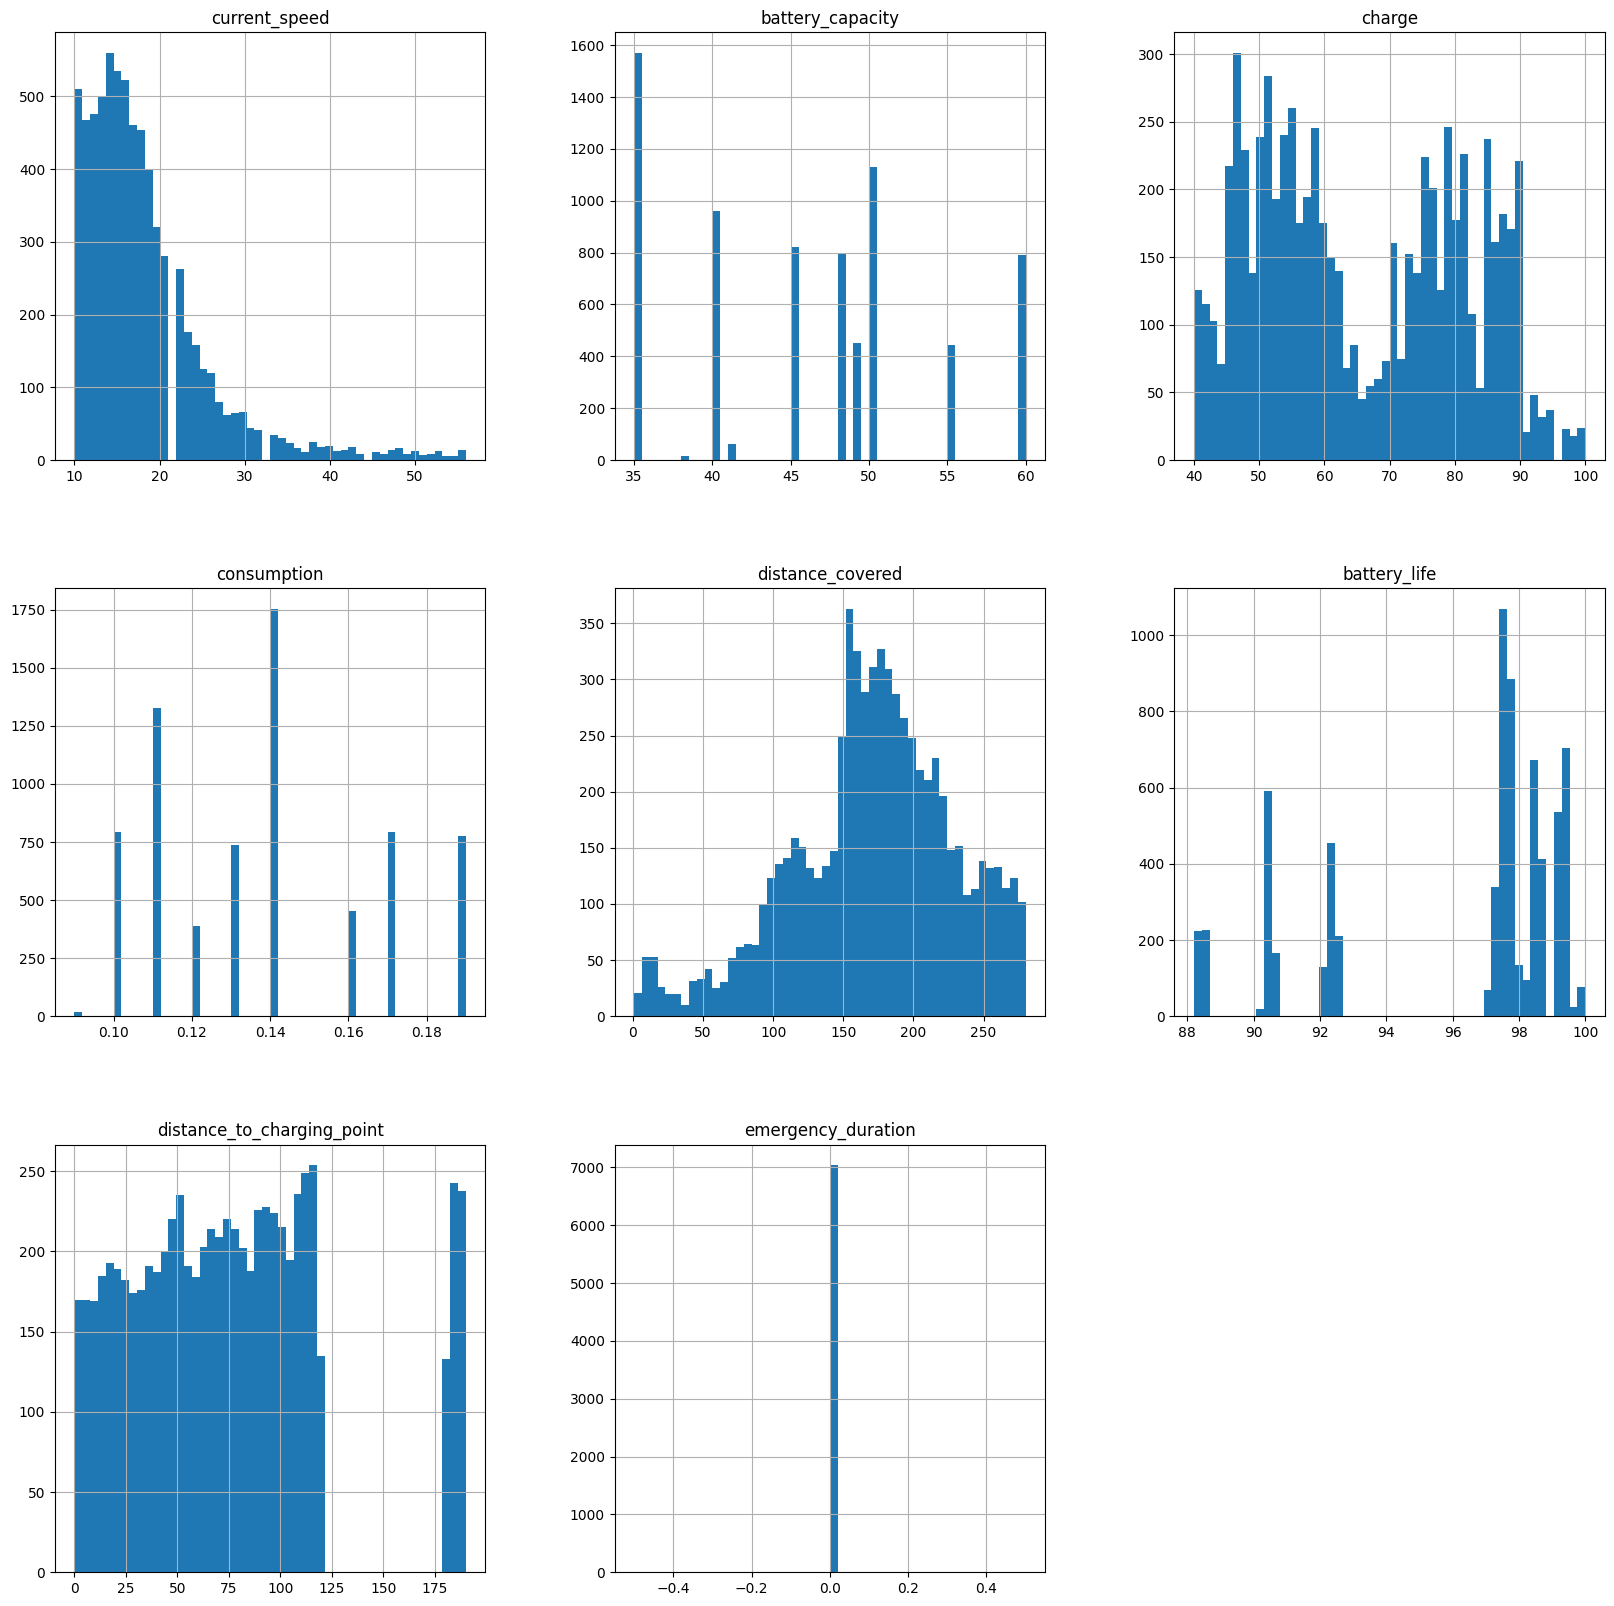

In [15]:
# Visualizing the distribution of the features
data[features].hist(figsize=(20, 20), bins=50)
plt.show()

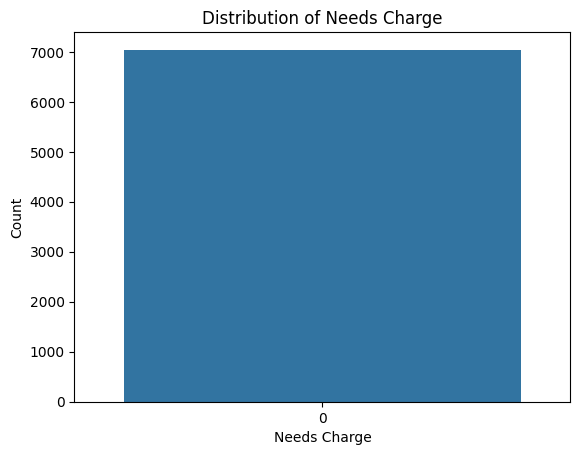

In [16]:
# Countplot of the target variable
data.reset_index(drop=True, inplace=True)
sns.countplot(data['needs_charge'])
plt.xlabel('Needs Charge')
plt.ylabel('Count')
plt.title('Distribution of Needs Charge')
plt.show()

/home/maith/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


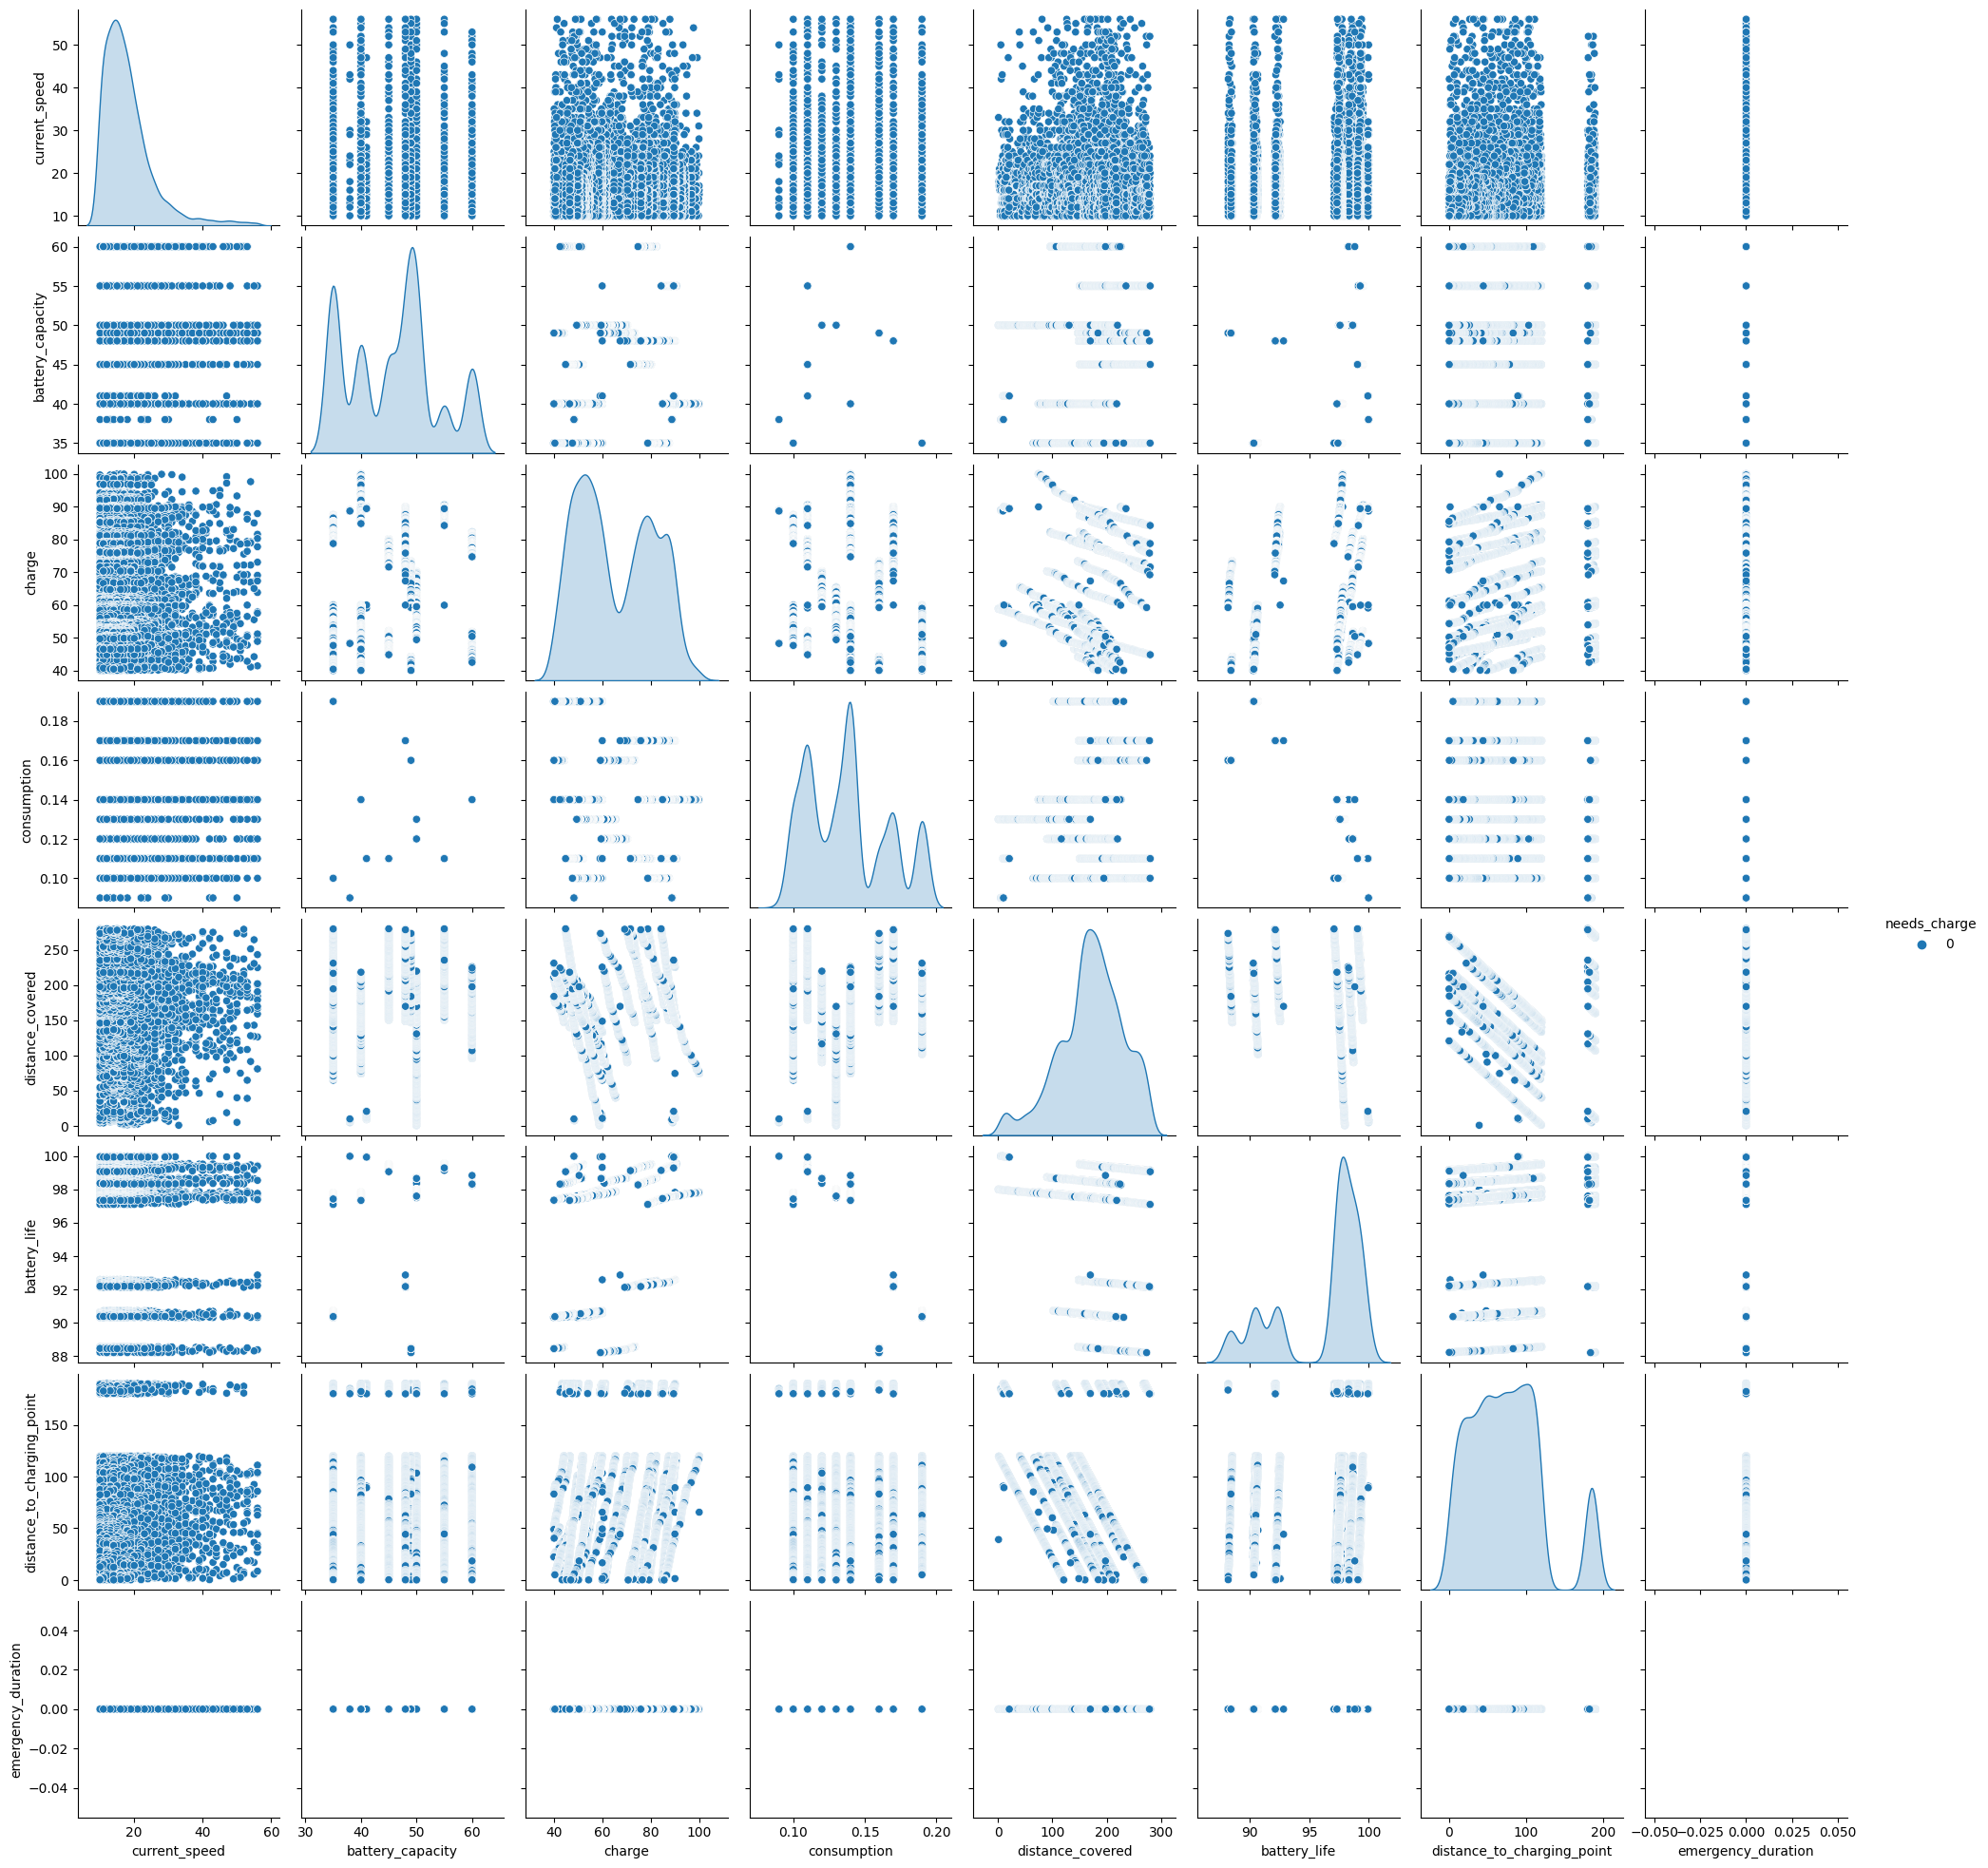

In [17]:
# Pairplot of the features and target variable
sns.pairplot(data[features + ['needs_charge']], hue='needs_charge')
plt.show()

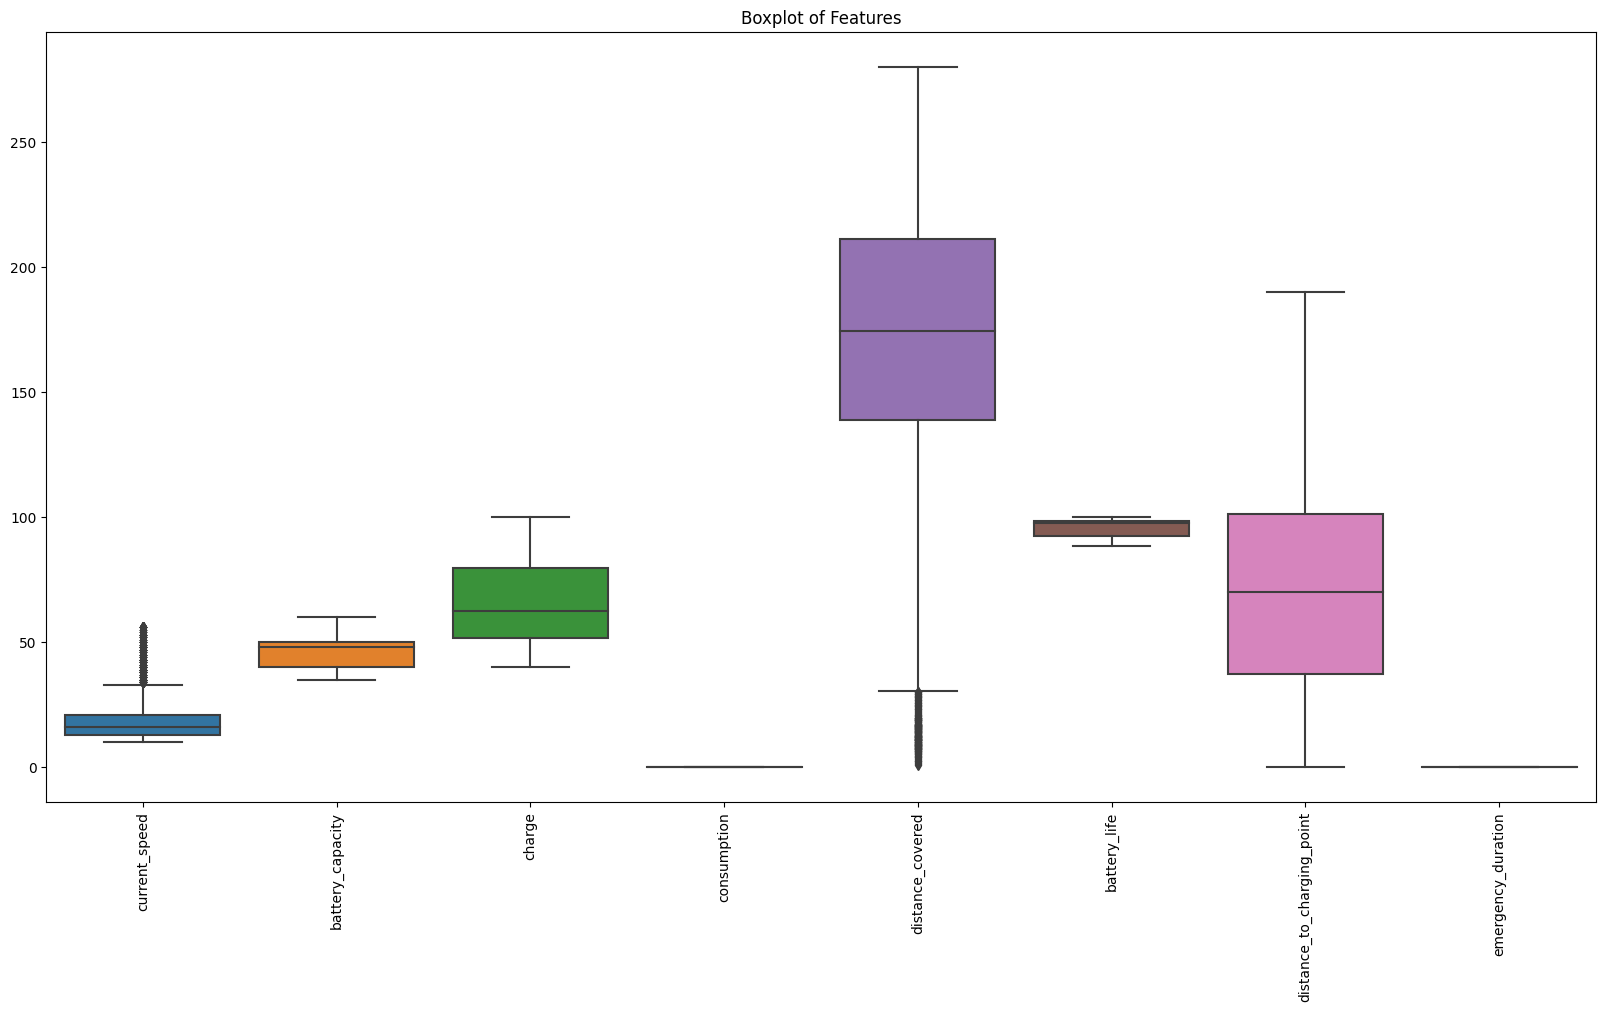

In [18]:
# Boxplots for each feature
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[features])
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

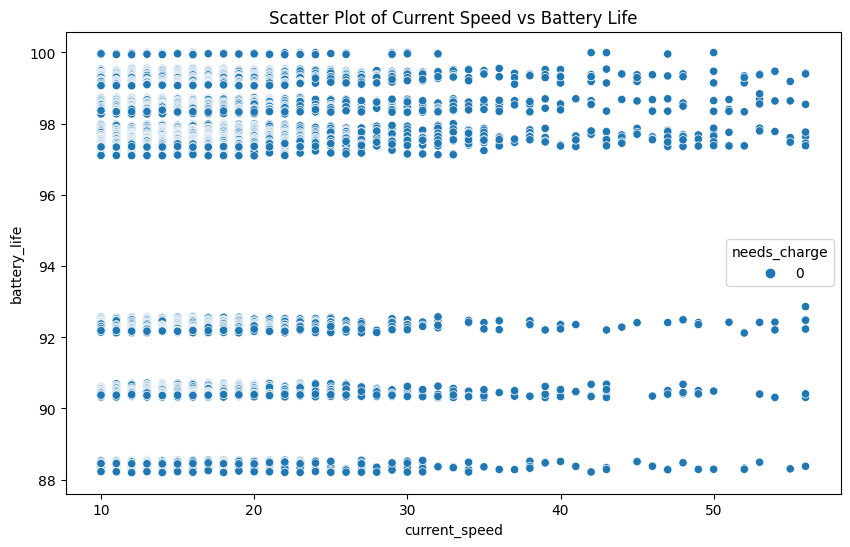

In [19]:
# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='needs_charge')
plt.title('Scatter Plot of Current Speed vs Battery Life')
plt.show()

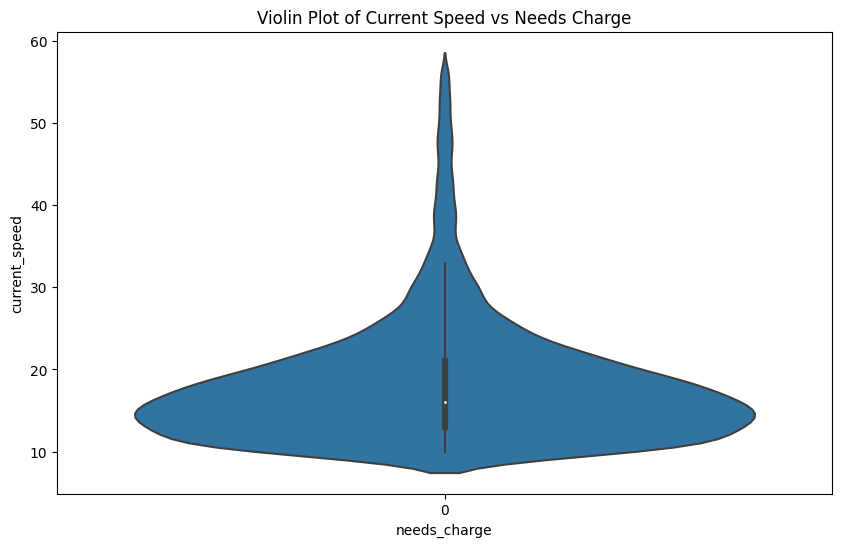

In [20]:
# Violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['needs_charge'], y=data['current_speed'])
plt.title('Violin Plot of Current Speed vs Needs Charge')
plt.show()

In [21]:
# cluster plot
from sklearn.cluster import KMeans

# Fit the KMeans algorithm to the data
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[features])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='cluster')
plt.title('Cluster Plot of Current Speed vs Battery Life')
plt.show()

/home/maith/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


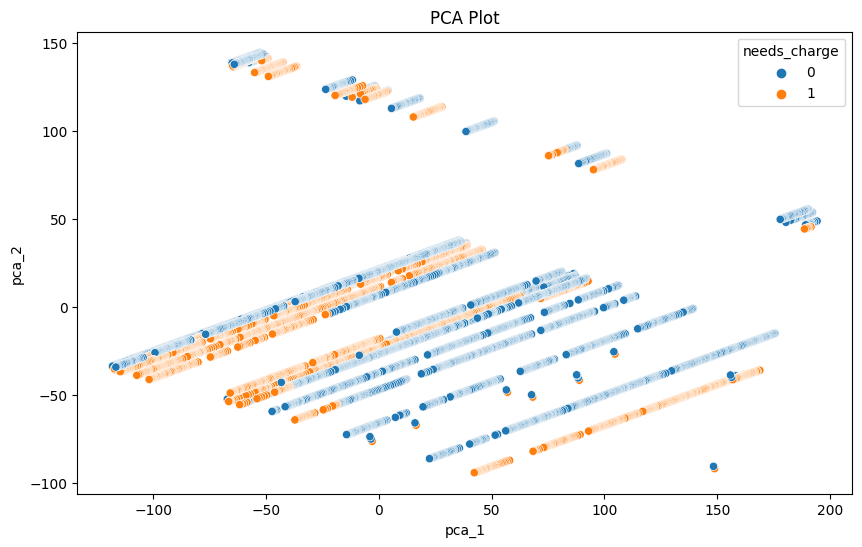

In [ ]:
# Dimensionality reduction plot
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])
data['pca_1'] = pca_result[:, 0]
data['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='pca_1', y='pca_2', hue='needs_charge')
plt.title('PCA Plot')
plt.show()

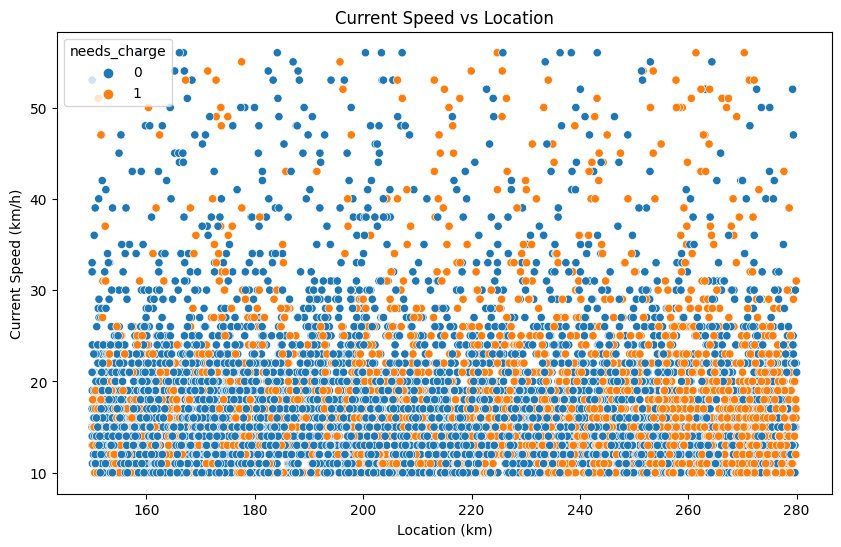

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='location', y='current_speed', hue='needs_charge')
plt.title('Current Speed vs Location')
plt.xlabel('Location (km)')
plt.ylabel('Current Speed (km/h)')
plt.show()

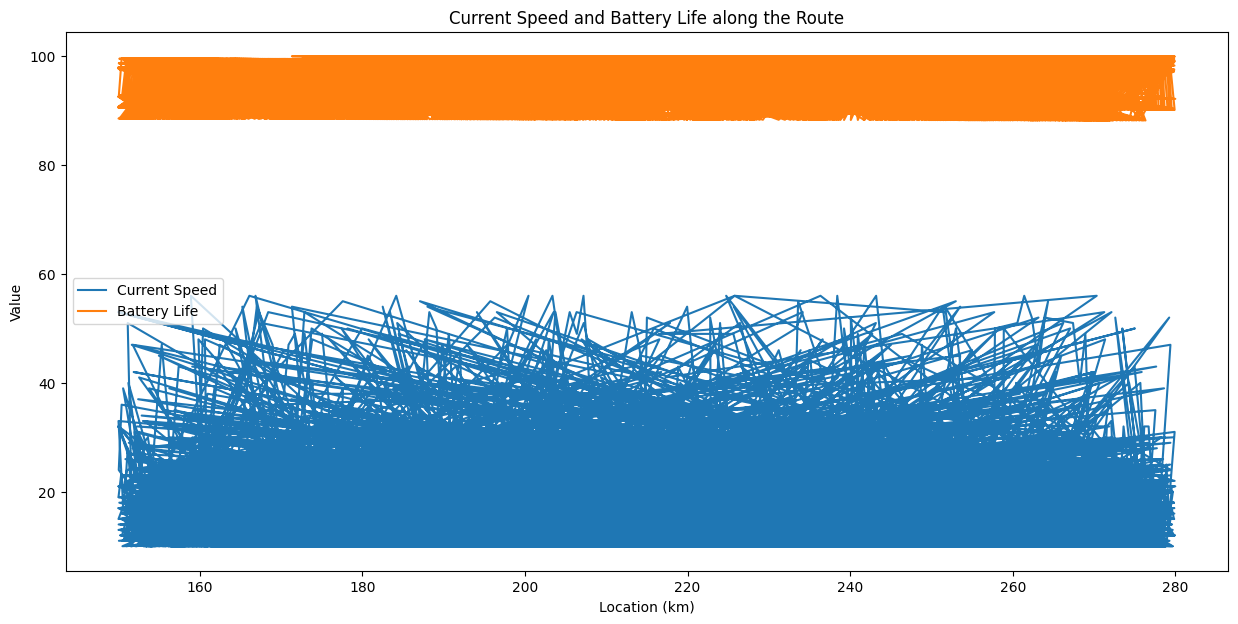

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data['location'], data['current_speed'], label='Current Speed')
plt.plot(data['location'], data['battery_life'], label='Battery Life')
plt.title('Current Speed and Battery Life along the Route')
plt.xlabel('Location (km)')
plt.ylabel('Value')
plt.legend()
plt.show()

Random Forest Classifier

In [ ]:
# Build the model
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Create a based model
rf = RandomForestClassifier(random_state=42)

In [ ]:
# Instantiate the grid search model
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total tim

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=2)

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters: ", best_params)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Train the model with the best parameters
model = grid_search.best_estimator_

In [ ]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1699
           1       1.00      1.00      1.00       816

    accuracy                           1.00      2515
   macro avg       1.00      1.00      1.00      2515
weighted avg       1.00      1.00      1.00      2515



In [ ]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1699
           1       1.00      1.00      1.00       816

    accuracy                           1.00      2515
   macro avg       1.00      1.00      1.00      2515
weighted avg       1.00      1.00      1.00      2515



In [ ]:
# %%
from sklearn.model_selection import cross_val_score

# Use cross_val_score function
# Cross-Validation
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print('Cross-Validation Accuracy Scores', scores)
print('Average Cross-Validation Accuracy', scores.mean())


Cross-Validation Accuracy Scores [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99761337]
Average Cross-Validation Accuracy 0.999761336515513


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Initialize the constructor
model = Sequential()

In [ ]:
# Add an input layer 
model.add(Dense(12, activation='relu', input_shape=(len(X.columns),)))

In [ ]:
# Add one hidden layer 
model.add(Dense(8, activation='relu'))

In [ ]:
# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                108       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5', save_best_only=True)]

In [ ]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, 
          validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
122/184 [==================>...........] - ETA: 0s - loss: 0.5937 - accuracy: 0.6849

184/184 [==============================] - 2s 4ms/step - loss: 0.5639 - accuracy: 0.6996 - val_loss: 0.4757 - val_accuracy: 0.7431
Epoch 2/100
 70/184 [==========>...................] - ETA: 0s - loss: 0.4302 - accuracy: 0.7920

/home/maith/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 1s 3ms/step - loss: 0.3598 - accuracy: 0.8623 - val_loss: 0.2588 - val_accuracy: 0.9054
Epoch 3/100
184/184 [==============================] - 1s 3ms/step - loss: 0.1871 - accuracy: 0.9322 - val_loss: 0.1411 - val_accuracy: 0.9602
Epoch 4/100
184/184 [==============================] - 1s 3ms/step - loss: 0.1079 - accuracy: 0.9702 - val_loss: 0.0867 - val_accuracy: 0.9789
Epoch 5/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9804 - val_loss: 0.0581 - val_accuracy: 0.9837
Epoch 6/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0497 - accuracy: 0.9867 - val_loss: 0.0437 - val_accuracy: 0.9877
Epoch 7/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0390 - accuracy: 0.9903 - val_loss: 0.0346 - val_accuracy: 0.9924
Epoch 8/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0320 - accuracy: 0.9928 - val_loss: 0.0294 - val_accuracy: 0.9920
Epoch 9/100

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

79/79 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9984
Test loss: 0.006198101677000523
Test accuracy: 0.9984095692634583


In [ ]:
def predict_need_charge(model, scaler, features):
    # print feature names and their values
       
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    50,  # current_speed
    1.2,  # battery_capacity
    56,  # charge
    0.1,  # consumption
    100,  # distance_covered
    20,  # battery_life
    5,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")

1/1 [==============================] - 0s 38ms/step
The car does not need to charge in the next station.


/home/maith/.local/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
